## Zebrafish anatomical annotation alignment and visualization

This is the last step of 4 to obtain a 3D reconstruction of anatomical annotations compatible with the 3D molecular reconstructions of the same zebrafish embryo.
The 3 previous steps do these operations:

1) Using Napari manually prepare anatomical annotations (i.e. labels) on H&E images of sections adjacent to the ones used for MALDI-MSI. Use ZFIN as areference to guide the annotation.Save as .npy

2) Using BigWarp, transform the anatomical label image into the MALDI-MSI coordinates of the adjacent MALDI image (extract an image from a molecule distributed in the whole section). Save the transformation matrix, apply it to the label .npy images and save the transformed images.

3) Scale the transformed images to get the same size as the MALDI-MSI images used for the molecular 3D reconstruction.

Once we obtain the correctly transformed and re-sized anatomical labels we can proceed to stuck them into a 3D reconstruction with the following steps.

### Imports

In [1]:
import logging
from multiprocessing import Pool
import os
import subprocess

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import ndimage
from scipy.ndimage import (
    zoom,
    median_filter,
    binary_dilation,
    binary_closing,
    binary_erosion,
    binary_fill_holes,
    gaussian_filter,
)
from scipy.interpolate import RegularGridInterpolator
from skimage import io
from skimage.color import rgb2gray
import mcubes

# Align images manually and show them

**Note:** Some H&E images were not usable for anatomical annotation, therefore the number between label images and MALDI-MSI does not match completely. Accordingly the images to skip have been commented out and the indexes adjusted accordingly.

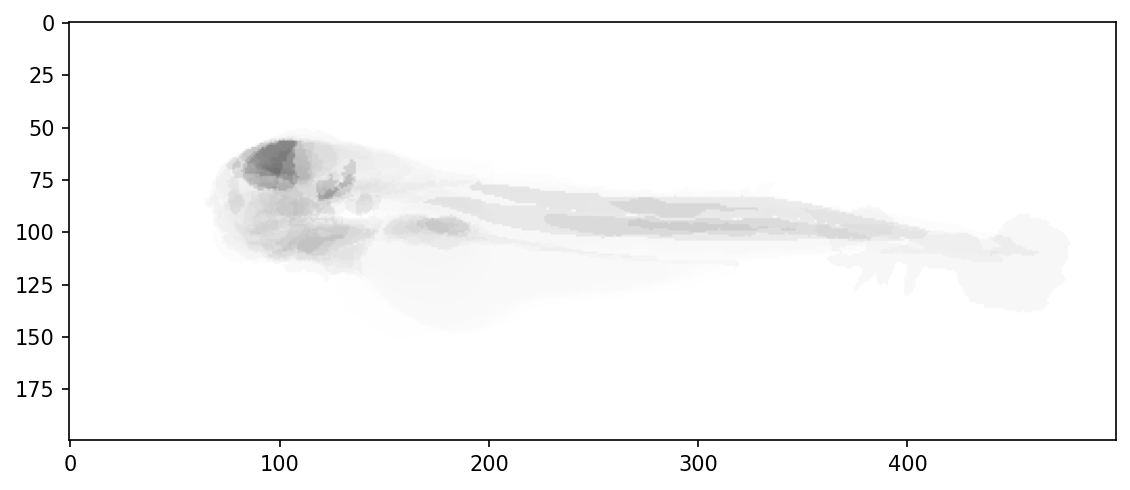

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.ndimage import rotate, shift

# Set the range of sections
start_section = 1 
end_section = 14

# Load the padded masks
input_folder ='/Users/leila/Downloads/all/72hpf_HE_consecutive_sections/Test2_Annotations_transformed_rescaled_renamed/' 
PATH_IMAGES = [os.path.join(input_folder, f'{section_index}_padded.npy') for section_index in range(start_section, end_section + 1)]

# Sort the images based on section index
ix_sort = np.argsort([int(os.path.basename(x).split('_')[0]) for x in PATH_IMAGES])
PATH_IMAGES = np.array(PATH_IMAGES)[ix_sort]

# Load the images
images = [np.load(x) for x in PATH_IMAGES]

# Get the number of images and section indices
num_images = len(images)
section_indices = [int(os.path.basename(x).split('_')[0]) for x in PATH_IMAGES]


# # Test Set 2 Define shift and rotate dictionaries
dict_shift = {
    ## 0: [-35, -125],
    1: [-58, -118],
    2: [-10, -110],
    3: [-67, -122],
    ## 4: [-38, -118],
    4 : [-45, -115], #5
    5: [-8, 3], #6
    6: [-18, 0], #7
    7: [0, 30], #8
    8: [-15,17], #9
    9: [-2, 3], #10
    10: [-5, 0], #11
    ## 12: [-32, -50], #12
    11: [-12, -90], #13
    ## 14: [-35, -100], #14
    12: [-70, -125], #15
    13: [-5, -110], #16
    14: [-63, -130], #17
    ## 18: [-10, -150], #18
}

dict_rotate = {
    ## 0: -10,
    1:-12,
    2: 0,
    3: -15,
    ## 4: -8, #4
    4: -10, #5
    5: -2, #6
    6: -8, #7
    7: -2, #8
    8: -6, #9
    9: 0, #10
    10: -2,  #11
    ## 12: -7, #12
    11: -3, #13
    ## 14: -11, #14
    12: -15, #15
    13: 0,  #16
    14: -12, #17
    ## 18: 0,# done #18
}

# List of colormaps to use for each image
colormaps = ['Greys']
#colormaps = ['Reds' if section_index == 9 else 'Greys' for section_index in section_indices]

# Set up the figure
fig = plt.figure(None, (9, 5), dpi=150)

# Transform and display images
images_transformed = []
for image_index in range(num_images):
    image_transform = images[image_index]
    image_transform = rotate(image_transform, dict_rotate[section_indices[image_index]], order=0, cval=np.nan)
    image_transform = shift(image_transform, dict_shift[section_indices[image_index]], order=0, cval=np.nan)
    
    # Crop the transformed image
    image_transform = image_transform[:200][:, :500]

    # Use a different colormap for each image
    cmap = colormaps[image_index % len(colormaps)]

    plt.imshow(image_transform, cmap=cmap, alpha=0.12)

    images_transformed.append(image_transform)

# Display the transformed images
plt.show()

In [3]:
print("Section indices from ix_sort:", ix_sort)
print("Keys in dict_rotate:", list(dict_rotate.keys()))
print("Keys in dict_shift:", list(dict_shift.keys()))

Section indices from ix_sort: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Keys in dict_rotate: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Keys in dict_shift: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


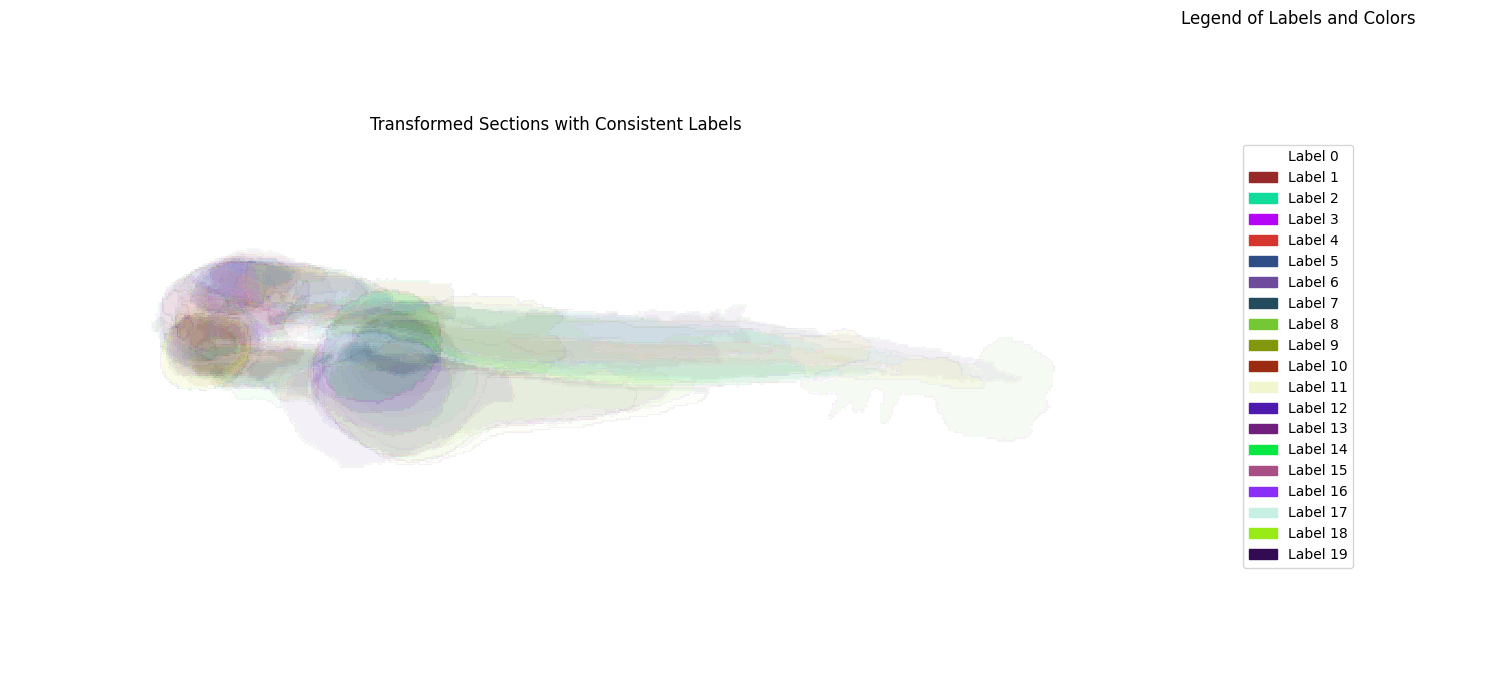

In [5]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.ndimage import rotate, shift
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec

# Define consistent colormap
num_labels = 256  # Assuming you have up to 255 unique labels
colors = np.random.RandomState(42).rand(num_labels, 3)  # Generate random colors
colors[0] = [1, 1, 1]  # Ensure background (label 0) is white
consistent_cmap = ListedColormap(colors)

# Generate label-to-color mapping
label_color_mapping = {label: color for label, color in enumerate(colors)}

# Set the range of sections
start_section = 1
end_section = 14

# Load the padded masks
input_folder = '/Users/leila/Downloads/all/72hpf_HE_consecutive_sections/Test2_Annotations_transformed_rescaled_renamed/' 
PATH_IMAGES = [os.path.join(input_folder, f'{section_index}_padded.npy') for section_index in range(start_section, end_section + 1)]

# Sort the images based on section index
ix_sort = np.argsort([int(os.path.basename(x).split('_')[0]) for x in PATH_IMAGES])
PATH_IMAGES = np.array(PATH_IMAGES)[ix_sort]

# Load the images
images = [np.load(x) for x in PATH_IMAGES]

# Define shift and rotate dictionaries
dict_shift = {
    1: [-58, -118],
    2: [-10, -110],
    3: [-67, -122],
    4: [-45, -115],  # Adjusted index for Test Set 2
    5: [-8, 3],
    6: [-18, 0],
    7: [0, 30],
    8: [-15, 17],
    9: [-2, 3],
    10: [-5, 0],
    11: [-12, -90],
    12: [-70, -125],
    13: [-5, -110],
    14: [-63, -130],
}

dict_rotate = {
    1: -12,
    2: 0,
    3: -15,
    4: -10,
    5: -2,
    6: -8,
    7: -2,
    8: -6,
    9: 0,
    10: -2,
    11: -3,
    12: -15,
    13: 0,
    14: -12,
}

# Set up the figure with GridSpec for layout
fig = plt.figure(figsize=(15, 7))
gs = GridSpec(1, 2, width_ratios=[3, 1])  # Grid layout: 3 parts for images, 1 part for legend

# Left: Transformed images
ax_img = fig.add_subplot(gs[0])
images_transformed = []

for image_index, image in enumerate(images):
    section_index = start_section + image_index  # Use correct section index for dictionary lookup
    
    # Rotate and shift the image
    image_transform = rotate(image, dict_rotate.get(section_index, 0), order=0, cval=0)
    image_transform = shift(image_transform, dict_shift.get(section_index, [0, 0]), order=0, cval=0)

    # Replace NaN values with 0 (optional)
    image_transform[np.isnan(image_transform)] = 0

    # Crop the transformed image
    image_transform = image_transform[:200, :500]

    # Display the image using the consistent colormap
    ax_img.imshow(image_transform, cmap=consistent_cmap, alpha=0.1)  # Use consistent_cmap

    # Save the transformed image for debugging
    images_transformed.append(image_transform)

ax_img.axis('off')
ax_img.set_title("Transformed Sections with Consistent Labels")

# Right: Legend
ax_legend = fig.add_subplot(gs[1])
patches = [
    mpatches.Patch(color=label_color_mapping[label], label=f"Label {label}")
    for label in range(len(label_color_mapping)) if label < 20
]  # Display only the first 20 labels for clarity

# Add the legend
ax_legend.legend(handles=patches, loc='center', ncol=1)
ax_legend.axis('off')
ax_legend.set_title("Legend of Labels and Colors")

# Show the figure
plt.tight_layout()
plt.show()

In [6]:
import napari
import numpy as np
from skimage.transform import resize
from scipy.ndimage import rotate, shift
from matplotlib.colors import ListedColormap

# Define the same consistent colormap used in matplotlib
num_labels = 256  # Maximum number of unique labels
colors = np.random.RandomState(42).rand(num_labels, 3)  # Random colors for labels
colors[0] = [1, 1, 1]  # Background color for label 0 (white)

# Map labels to RGB colors as a dictionary for Napari
custom_colormap = {label: tuple(color) for label, color in enumerate(colors)}

# Assuming `images_transformed` contains your transformed label images
# Stack transformed images to form a 3D volume
volume = np.stack(images_transformed, axis=0)

# Initialize Napari viewer
%gui qt
viewer = napari.Viewer(ndisplay=3)
viewer.theme = 'light'

# Add the label volume to Napari
label_layer = viewer.add_labels(
    volume,
    name="Transformed Labels",
    scale=[3.5, 1, 1],
    opacity=0.9  # Adjust opacity if needed
)

# Apply the custom colormap
label_layer.color = custom_colormap

# Run the Napari viewer
napari.run()


2024-12-19 17:12:20.644 python[82221:1889504] +[IMKClient subclass]: chose IMKClient_Modern
2024-12-19 17:12:20.644 python[82221:1889504] +[IMKInputSession subclass]: chose IMKInputSession_Modern


In [6]:
np.save("anatomy_72hpf_updated.npy", volume)

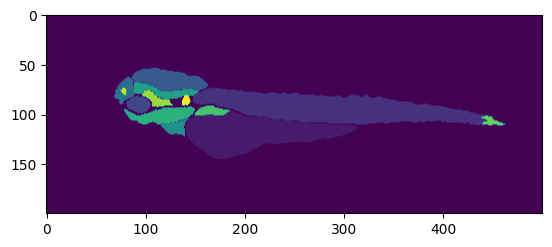

In [7]:
labels=np.load('anatomy_72hpf_updated.npy')
plt.imshow(labels[6])